In [6]:
!pip install numpy pandas matplotlib tensorflow==2.6 transformers

Looking in indexes: https://pypi.douban.com/simple
     |████████████████████████████████| 458.3 MB 1.5 kB/s 
     |████████████████████████████████| 14.8 MB 25 kB/s 
     |████████████████████████████████| 132 kB 46.0 MB/s 
     |████████████████████████████████| 4.0 MB 44.5 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30692 sha256=ccb888aa87cab13253e1bba7d79bcfcfe92f0e81fdb53bfe8887bc654c3c7c91
  Stored in directory: /home/nan/.cache/pip/wheels/c0/0f/cf/8a390741e47414d6683001332827698b1e76aefd8e9cf0d9ef
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77254 sha256=587a73c4f651fa16494fac365fc292afb120391b2a4836d75d5d885fa2dd5e2d
  Stored in directory: /home/nan/.cache/pip/wheels/4b/d6/4a/8f624bbcf3a01720a9fe04df85631ff62b56ed6f19be2a90f9
Successfully built clang wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.0.0
    Uninstalling typing-extensions-4.0.0:
      Successfull

In [7]:
import re
import os
import shutil
import zipfile
import random
import numpy as np
import pandas as pd
from pathlib import Path
# from ast import literal_eval
from transformers import BertTokenizer,  BertConfig, TFBertModel
import tensorflow as tf
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')

In [9]:
print(tf.__version__)
print(tf.test.is_gpu_available())
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(gpus[-1])

2.7.0
False


2021-12-07 16:04:46.199299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-07 16:04:46.199368: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# 数据集整理
## 读取数据
### 压缩和解压zip文件

In [10]:
class ZipHanding:
    """Decompress the ZIP file or compress the file into a ZIP file"""
    def unzip(self, zipPath, dp=None):  
        """
        Unzip zip file to a folder
        
        Parameters
        ---------
        zipPath: Zip file path 
        dp: Decompression path

        Returns
        ---------
        dir_path: The path of the extracted folder

        Raises
        ---------
        """
        if dp == None:
            ## By default, it is decompressed to the current directory
            dp = zipPath.rsplit('.', 1)[0]
        if os.path.exists(dp):
            shutil.rmtree(dp)        
        with zipfile.ZipFile(zipPath, 'r') as f:
            for fn in f.namelist():
                f.extract(fn, dp)
        return dp

    def rm_file_folder(self, fp):
        '''
        remove file or folder
        '''
        if os.path.exists(fp) and os.path.isfile(fp):
            os.remove(fp)
        elif os.path.exists(fp) and os.path.isdir(fp):
            shutil.rmtree(fp)
        else:
            raise FileNotFoundError('File not found')

    def rename_correctly(self, string):
        '''
        Rename the garbled characters extracted from the window package
        '''
        try:
            new_string = string.encode('cp437').decode('utf-8')
        except:
            try:
                new_string = string.encode('cp437').decode('gbk')
            except:
                new_string = string.encode('utf-8').decode('utf-8')
        return  new_string
        
    def rm_special_name_folder(self, dir_path, folder_name='__MACOSX'): 
        '''
        Delete the folder named 'xxxx' if it exists.
        The default folder name is __MACOSX.
        '''
        for root, dirs, files in os.walk(dir_path, topdown=False):
            for name in dirs:
                if name == folder_name :
                    shutil.rmtree(os.path.join(root, name))  

    def standard_zip_dir(self, dir_path):
        '''
        Deal with garbled characters in decompressed files and folder reuse problems
        '''
        for root, dirs, filenames in os.walk(dir_path):
            for fn in filenames:
                fp = os.path.join(root, fn)
                new_fp = os.path.join(dir_path, self.rename_correctly(fn))
                os.rename(fp, new_fp)
                
        for root, dirs, filenames in os.walk(dir_path):
            for folder in dirs:
                dp = os.path.join(root, folder)
                self.rm_file_folder(dp)
                self.rm_special_name_folder(dir_path)   
                 
    @classmethod
    def decompression(cls, zipPath):
        dir_path = cls().unzip(zipPath)
        cls().standard_zip_dir(dir_path)      
        return dir_path

    @classmethod
    def zip_file(cls, dfp, out_path=None):
        """
        Compresses the specified folder

        Parameters
        ---------
        dfp: Destination folder or file path.
        out_path: Save path of the compressed file +xxxx.zip.

        Returns
        ---------
        """

        if os.path.isdir(dfp):   
            if out_path == None:
                out_path = dfp + '.zip'
            with zipfile.ZipFile(out_path, "w", zipfile.ZIP_DEFLATED) as f:
                    for root, _, filenames in os.walk(dfp):
                        for fn in filenames:
                            f.write(filename=os.path.join(root, fn), arcname=fn)
        else:
            if out_path == None:
                out_path = dfp.rsplit('.', 1)[0] + '.zip'
            with zipfile.ZipFile(out_path, "w", zipfile.ZIP_DEFLATED) as f:
                f.write(dfp, dfp.rsplit('/', 1)[1])
        print(out_path)


zipPath = './data/招股说明书三元组数据集_云测早期标注.zip'
dir_path = ZipHanding.decompression(zipPath)
print(dir_path)

dfp = './data/招股说明书三元组数据集_云测早期标注'
ZipHanding.zip_file(dfp)

./data/招股说明书三元组数据集_云测早期标注
./data/招股说明书三元组数据集_云测早期标注.zip


### 处理解压的文件中的乱码和文件夹复用问题

### 读取三元组数据json文件

In [12]:
def json_to_df(path, nrows=False):
    '''
    Read a TRIplet data JSON file
    
    Parameters
    ---------    
    path: file path
    nrows: int, optional
           The number of lines from the line-delimited jsonfile that has to be read
           The default is false, all the rows will be returned.
    Returns
    ---------  
    df: DataFrame
    '''
    if nrows:
        df = pd.read_json(path, nrows=nrows, lines=True)
    else:
        df = pd.read_json(path, lines=True)

    return df


### 从zip或文件夹中读取多个json文件合并

In [13]:
def merge_df(path):
    if path.rsplit('.', 1)[1]=='zip':
        dir_path = ZipHanding.decompression(path)
    else:
        dir_path = path
    total_df = pd.DataFrame()
    for fn in os.listdir(dir_path):
        df = json_to_df(os.path.join(dir_path, fn))
        df_fn = fn[:fn.rfind('.')]
        df.insert(0, 'fn', df_fn)
        total_df =  total_df.append(df)
    total_df.reset_index(drop=True, inplace=True)
    print(f'original data size: {total_df.shape}') #
    # print(f'original data sample: {df.sample(5)}\n')
    shutil.rmtree(dir_path)
    return total_df  

path1 = './data/招股说明书三元组数据集_内部标注.zip'
merge_df(path1)

original data size: (837, 3)


,fn,text,spo_list
0,万林股份3,2011年9月29日，公司第一届薪酬与考核委员会第二次会议通过了公司薪酬福利管理制度，具体如...,"[{'predicate': '会议召开日期', 'object_type': '公司', ..."
1,万林股份3,2012年末、2013年末及2014年末，公司应收新港船务的款项系盈利港务对新港船务的借款。...,"[{'predicate': '会议召开日期', 'object_type': '公司', ..."
2,万林股份3,"2008年3月12日，盈利港务董事会作出决议，将注册资本由500万美元增至3,500万美元，...","[{'predicate': '会议召开日期', 'object_type': '公司', ..."
3,万林股份3,1、黄保忠，男，1957年1月出生，硕士。1989年至1993年任上海东申进出口公司副总经理...,"[{'predicate': '出生日期', 'object_type': '日期', 's..."
4,万林股份3,2、孙玉峰，男，1961年5月出生，博士，高级经济师。2003年至2011年任日照港股份有限...,"[{'predicate': '出生日期', 'object_type': '日期', 's..."
...,...,...,...
832,长飞光纤,"2015年度、2016年度和2017年度，本公司的财务费用分别为12,582.87万元、11...","[{'predicate': '财务费用', 'object_type': '日期', 's..."
833,长飞光纤,"本公司2015年度、2016年度及2017年度的资产减值损失分别为3,504.65万元、1,...","[{'predicate': '资产减值损失', 'object_type': '金额', ..."
834,长飞光纤,"2015年度、2016年度和2017年度，本公司的非经常性损益额分别为6,605.22万元、...","[{'predicate': '非经常性损益', 'object_type': '日期', ..."
835,长飞光纤,"截至2018年3月31日，公司资产总额达到965,787.67万元，较上年末增长5.35%，...","[{'predicate': '总资产', 'object_type': '金额', 'su..."


### 读取关系标签数

In [14]:
def read_schemads(path_or_df):
    if not isinstance(path_or_df, pd.DataFrame):
        schemads_path = path_or_df
        predicate_data = pd.read_json(schemads_path, lines=True)
        id2p = predicate_data['predicate'].drop_duplicates().reset_index(drop=True).to_dict()
    else:
        df = path_or_df
        id2p = df['spo_list'].apply(lambda spo_list: [spo['predicate'] for spo in spo_list])
        id2p = id2p.explode().drop_duplicates().reset_index(drop=True).to_dict()
    p2id = dict(zip(id2p.values(), id2p.keys()))
    print(f'length of p2id :{len(p2id)}')#
    print(f'random p2id sample:{random.sample(p2id.items(), 5)}')#
    return id2p, p2id

## 招股说明书三元组数据集

In [15]:
path1 = './data/招股说明书三元组数据集_云测早期标注.zip'
df1 = merge_df(path1)

# path2 = './data/招股说明书三元组数据集_内部标注.zip'
# df2 = merge_df(path2)

path3 = './data/招股说明书三元组数据集_云测标注.zip'
df3= merge_df(path3)

df = pd.concat([df1, df3], ignore_index=True)
print(f'df.shape: {df.shape}')
id2p, p2id = read_schemads(df)

original data size: (9500, 3)
original data size: (17288, 3)
df.shape: (26788, 3)
length of p2id :152
random p2id sample:[('其他非流动负债的余额', 144), ('变更日期', 2), ('出具日期', 1), ('其他非流动负债', 149), ('存货账面价值', 120)]


## 清洗数据

In [16]:
def clean_spo(spo_list):
    for spo in spo_list:
        spo['predicate'] = spo['predicate'].lower()
        spo['subject'] = spo['subject'].lower()
        spo['object'] = spo['object'].lower()
    return spo_list

def data_clean(df):
    df.dropna(how='any', inplace=True)
    df = df[df['spo_list'].apply(lambda x: len(x)>0)]
    df.drop_duplicates(subset=['text'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['text'] = df['text'].str.lower()
    df['spo_list'] = df['spo_list'].apply(clean_spo)
    print(f'Real data size is {df.shape[0]}')
    return df
    
df = data_clean(df)

Real data size is 16935


## 划分数据集

In [17]:
train_size=0.9
train_data = df.sample(frac=train_size,random_state=200)
dev_data = df.drop(train_data.index)
dev_data.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)
print(f'Train data size: {train_data.shape}') #
print(f'Validation data size: {dev_data.shape}') 

train_text = train_data['text'].to_list()
train_spo = train_data['spo_list'].to_list()

dev_text = dev_data['text'].to_list()
dev_spo = dev_data['spo_list'].to_list()

Train data size: (15242, 3)
Validation data size: (1693, 3)


## 标签集分布

Total number of p2id category is 153, actual number of labels that meet the requirements is 90
Spo count is 43388, number of valid labels is 22895


,spo_list,count,quantity_required,compliance
0,人物-任职公司-公司,3227,200,1
1,人物-任职公司-日期,1,1,0
2,人物-任职日期-日期,3919,200,1
3,人物-出生日期-日期,758,200,1
4,人物-国籍-国家,789,200,1
...,...,...,...,...
148,比率-存货周转率-日期,249,200,1
149,比率-应收账款周转率-日期,262,200,1
150,比率-流动比率-日期,223,200,1
151,比率-资产负债率-日期,224,200,1


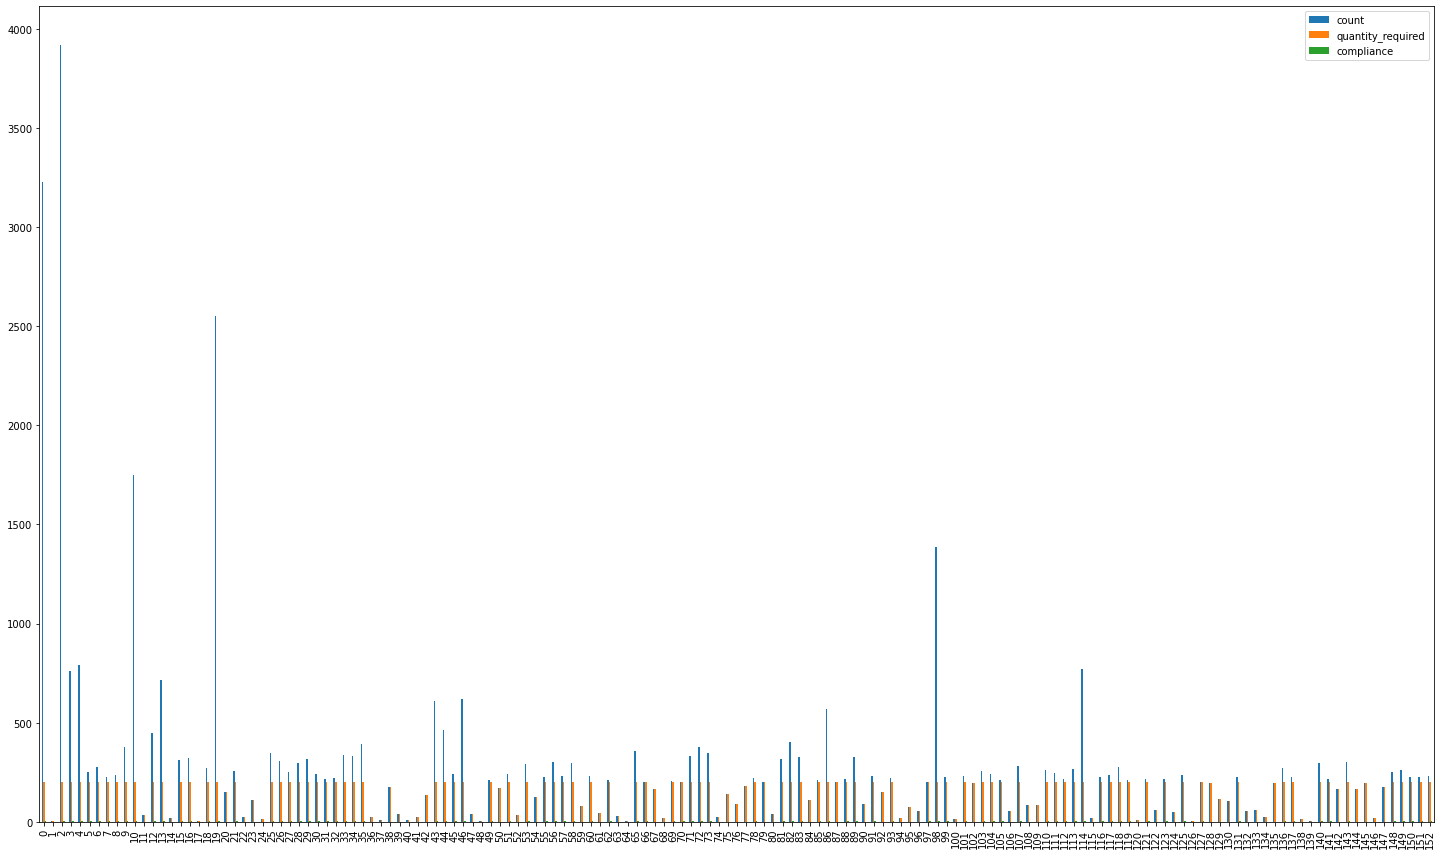

In [19]:
def calculate_tag(df, dataset_name, label_range):
    '''
    label_range: Number range of a single label
    '''
    start, end = label_range
    spo = df['spo_list'].explode().reset_index(drop=True)
    spo_group = spo.apply(lambda x: '-'.join([ x['subject_type'], x['predicate'] , x['object_type']]))
    spo_group_count = spo_group.groupby(spo_group).count().reset_index(name='count')
    spo_group_count['quantity_required'] = spo_group_count['count'].apply(lambda x: start if start <= x < end  else x)
    spo_group_count['compliance'] = spo_group_count['count'].apply(lambda x: 1 if start <= x < end  else 0)
    spo_group_count.to_csv('./data/' + dataset_name + '_spo_group_count.csv', index=False, encoding='utf_8_sig')
    spo_group_count.plot(kind='bar', figsize=(25,15))
    print(f"Total number of p2id category is {spo_group_count['count'].shape[0]}, actual number of labels that meet the requirements is {spo_group_count['compliance'].sum()}")
    print(f"Spo count is {spo_group_count['count'].sum()}, number of valid labels is {spo_group_count['quantity_required'].sum()}")
    return spo_group_count

dataset_name = '招股说明书'
label_range = [200, float('inf')]
spo_group_count = calculate_tag(df, dataset_name, label_range)
spo_count = spo_group_count['count'].sum()
spo_group_count

In [12]:
def proceed_data(text_list, spo_list, p2id, tokenizer, MAX_LEN, spo_count):
    id_label = {}
    ct = len(text_list)
    MAX_LEN = MAX_LEN
    input_ids = np.zeros((spo_count,MAX_LEN),dtype='int32')
    attention_mask = np.zeros((spo_count,MAX_LEN),dtype='int32')
    start_tokens = np.zeros((spo_count,MAX_LEN),dtype='int32')
    end_tokens = np.zeros((spo_count,MAX_LEN),dtype='int32')
    send_s_po = np.zeros((spo_count,2),dtype='int32')
    object_start_tokens = np.zeros((spo_count,MAX_LEN,len(p2id)),dtype='int32')
    object_end_tokens = np.zeros((spo_count,MAX_LEN,len(p2id)),dtype='int32')
    index_vaild = -1
    for k in range(ct):
        context_k = text_list[k].lower().replace(' ','')
        enc_context = tokenizer.encode(context_k,max_length=MAX_LEN,truncation=True)      
        start = []
        S_index = []
        for j in range(len(spo_list[k])):
            answers_text_k = spo_list[k][j]['subject'].lower().replace(' ','')
            chars = np.zeros((len(context_k)))
            index = context_k.find(answers_text_k)
            chars[index:index+len(answers_text_k)]=1
            offsets = []
            idx=0
            for t in enc_context[1:]:
                w = tokenizer.decode([t])
                if '#' in w and len(w)>1:
                    w = w.replace('#','')
                if w == '[UNK]':
                    w = '。'
                offsets.append((idx,idx+len(w)))
                idx += len(w)
            toks = []
            for i,(a,b) in enumerate(offsets):
                sm = np.sum(chars[a:b])
                if sm>0: 
                    toks.append(i) 
            if len(toks)>0:
                S_start = toks[0]+1
                S_end = toks[-1]+1
                if (S_start,S_end) not in start:
                    index_vaild += 1
                    start.append((S_start,S_end))
                    input_ids[index_vaild,:len(enc_context)] = enc_context
                    attention_mask[index_vaild,:len(enc_context)] = 1
                    start_tokens[index_vaild,S_start] = 1
                    end_tokens[index_vaild,S_end] = 1
                    send_s_po[index_vaild,0] = S_start
                    send_s_po[index_vaild,1] = S_end
                    S_index.append([j,index_vaild])
                else:
                    S_index.append([j,index_vaild])
        if len(S_index) > 0:
            for index_ in range(len(S_index)):
                #随机选取object的首位，如果选取错误，则作为负样本
                object_text_k = spo_list[k][S_index[index_][0]]['object'].lower().replace(' ','')
                predicate = spo_list[k][S_index[index_][0]]['predicate']
                p_id = p2id[predicate]
                chars = np.zeros((len(context_k)))
                index = context_k.find(object_text_k)
                chars[index:index+len(object_text_k)]=1
                offsets = [] 
                idx = 0
                for t in enc_context[1:]:
                    w = tokenizer.decode([t])
                    if '#' in w and len(w)>1:
                        w = w.replace('#','')
                    if w == '[UNK]':
                        w = '。'
                    offsets.append((idx,idx+len(w)))
                    idx += len(w)
                toks = []
                for i,(a,b) in enumerate(offsets):
                    sm = np.sum(chars[a:b])
                    if sm>0: 
                        toks.append(i) 
                if len(toks)>0:
                    id_label[p_id] = predicate
                    P_start = toks[0]+1
                    P_end = toks[-1]+1
                    object_start_tokens[S_index[index_][1]][P_start,p_id] = 1
                    object_end_tokens[S_index[index_][1]][P_end,p_id] = 1
    return input_ids[:index_vaild], attention_mask[:index_vaild], start_tokens[:index_vaild], end_tokens[:index_vaild], send_s_po[:index_vaild], \
           object_start_tokens[:index_vaild], object_end_tokens[:index_vaild], id_label

In [13]:
%%time
MAX_LEN = 256  
pretrained_path = '../model_dirs/chinese-bert-wwm-ext'  
tokenizer = BertTokenizer.from_pretrained(pretrained_path)
input_ids, attention_mask, start_tokens, end_tokens, send_s_po, object_start_tokens, object_end_tokens, id_label \
= proceed_data(train_text, train_spo, p2id, tokenizer, MAX_LEN, spo_count)

print(f'start tokens shape: {start_tokens.shape}')

val_inputs = tokenizer(dev_text, max_length=MAX_LEN, padding='max_length', truncation=True, return_tensors='tf') 
val_input_ids, val_attention_mask = val_inputs['input_ids'], val_inputs['attention_mask']

start tokens shape: (26047, 256)
CPU times: user 4min 15s, sys: 1.68 s, total: 4min 16s
Wall time: 4min 17s


2021-10-11 11:12:23.712300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-11 11:12:23.712862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-11 11:12:23.713334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-11 11:12:23.714330: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-10-11 11:12:23.714554: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1594] Could not ident

In [14]:
def new_loss(true,pred):
    true = tf.cast(true,tf.float32)
    loss = K.sum(K.binary_crossentropy(true, pred))
    return loss

In [15]:
class LayerNormalization(tf.keras.layers.Layer):
    """(Conditional) Layer Normalization
    hidden_*系列参数仅为有条件输入时(conditional=True)使用
    """
    def __init__(
        self,
        center=True,
        scale=True,
        epsilon=None,
        conditional=False,
        hidden_units=None,
        hidden_activation='linear',
        hidden_initializer='glorot_uniform',
        **kwargs):
        super(LayerNormalization, self).__init__(**kwargs)
        self.center = center
        self.scale = scale
        self.conditional = conditional
        self.hidden_units = hidden_units
        self.hidden_activation = tf.keras.activations.get(hidden_activation)
        self.hidden_initializer = tf.keras.initializers.get(hidden_initializer)
        self.epsilon = epsilon or 1e-12
        
    def compute_mask(self, inputs, mask=None):
        if self.conditional:
            masks = mask if mask is not None else []
            masks = [m[None] for m in masks if m is not None]
            if len(masks) == 0:
                return None
            else:
                return K.all(K.concatenate(masks, axis=0), axis=0)
        else:
            return mask
        
    def build(self, input_shape):
        super(LayerNormalization, self).build(input_shape)
        if self.conditional:
            shape = (input_shape[0][-1],)
        else:
            shape = (input_shape[-1],)
        if self.center:
            self.beta = self.add_weight(
                shape=shape, initializer='zeros', name='beta')
        if self.scale:
            self.gamma = self.add_weight(
                shape=shape, initializer='ones', name='gamma')
        if self.conditional:
            if self.hidden_units is not None:
                self.hidden_dense = tf.keras.layers.Dense(
                    units=self.hidden_units,
                    activation=self.hidden_activation,
                    use_bias=False,
                    kernel_initializer=self.hidden_initializer)
            if self.center:
                self.beta_dense = tf.keras.layers.Dense(
                    units=shape[0], use_bias=False, kernel_initializer='zeros')
            if self.scale:
                self.gamma_dense = tf.keras.layers.Dense(
                    units=shape[0], use_bias=False, kernel_initializer='zeros')

    def call(self, inputs):
        """如果是条件Layer Norm，则默认以list为输入，第二个是condition
        """
        if self.conditional:
            inputs, cond = inputs
            if self.hidden_units is not None:
                cond = self.hidden_dense(cond)
            for _ in range(K.ndim(inputs) - K.ndim(cond)):
                cond = K.expand_dims(cond, 1)
            if self.center:
                beta = self.beta_dense(cond) + self.beta
            if self.scale:
                gamma = self.gamma_dense(cond) + self.gamma
        else:
            if self.center:
                beta = self.beta
            if self.scale:
                gamma = self.gamma
        outputs = inputs
        if self.center:
            mean = K.mean(outputs, axis=-1, keepdims=True)
            outputs = outputs - mean
        if self.scale:
            variance = K.mean(K.square(outputs), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            outputs = outputs / std
            outputs = outputs * gamma
        if self.center:
            outputs = outputs + beta
        return outputs


In [16]:
def extract_subject(inputs):
    """根据subject_ids从output中取出subject的向量表征
    """
    output, subject_ids = inputs
    start = tf.gather(output,subject_ids[:,0],axis=1,batch_dims=1)
    end = tf.gather(output,subject_ids[:,1],axis=1,batch_dims=1)
    subject = tf.keras.layers.Concatenate(axis=1)([start, end])
    return subject
'''
   output.shape = 
   (None,128,768)
   subjudec_ids.shape = (None,2)
   start.shape = (None,None,768)
   subject.shape = (None,None,1536)
   subject[:,0].shape = (None,1536)
   这一部分给出各个变量的shape应该一目了然
'''
   
def build_model_2(pretrained_path, MAX_LEN, p2id):
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    s_po_index =  tf.keras.layers.Input((2,), dtype=tf.int32)
    
    bert_model = TFBertModel.from_pretrained(pretrained_path, output_hidden_states=True)
    outputs = bert_model(ids, attention_mask=att)
    x, _, hidden_states  = outputs[:3]
    layer_1 = hidden_states[-1]
    start_logits = tf.keras.layers.Dense(1,activation = 'sigmoid')(layer_1)
    start_logits = tf.keras.layers.Lambda(lambda x: x**2)(start_logits)
    
    end_logits = tf.keras.layers.Dense(1,activation = 'sigmoid')(layer_1)
    end_logits = tf.keras.layers.Lambda(lambda x: x**2)(end_logits)
    
    subject_1 = extract_subject([layer_1,s_po_index])
    Normalization_1 = LayerNormalization(conditional=True)([layer_1, subject_1])
    
    op_out_put_start = tf.keras.layers.Dense(len(p2id),activation = 'sigmoid')(Normalization_1)
    op_out_put_start = tf.keras.layers.Lambda(lambda x: x**4)(op_out_put_start)
    
    op_out_put_end = tf.keras.layers.Dense(len(p2id),activation = 'sigmoid')(Normalization_1)
    op_out_put_end = tf.keras.layers.Lambda(lambda x: x**4)(op_out_put_end)
    
    model = tf.keras.models.Model(inputs=[ids, att, s_po_index], outputs=[start_logits, end_logits, op_out_put_start, op_out_put_end])
    model_2 = tf.keras.models.Model(inputs=[ids, att], outputs=[start_logits,end_logits])
    model_3 = tf.keras.models.Model(inputs=[ids, att, s_po_index], outputs=[op_out_put_start, op_out_put_end])
    return model, model_2, model_3


In [17]:
def rematch_text_word(tokenizer,text,enc_context,enc_start,enc_end):
    span = [a.span()[0] for a in re.finditer(' ', text)]
    decode_list = [tokenizer.decode([i]) for i in enc_context][1:]
    start = 0
    end = 0
    len_start = 0
    for i in range(len(decode_list)):
        if i ==  enc_start - 1:
            start = len_start
        j = decode_list[i]
        if '#' in j and len(j)>1:
            j = j.replace('#','')
        if j == '[UNK]':
            j = '。'
        len_start += len(j)
        if i == enc_end - 1:
            end = len_start
            break
    for span_index in span:
        if start >= span_index:
            start += 1
            end += 1
        if end > span_index and span_index>start:
            end += 1
    return text[start:end]


class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, model_2, model_3, id2tag, va_text_list, va_spo_list, va_input_ids, va_attention_mask, tokenizer, folder_path):
        super(Metrics, self).__init__()
        self.model_2 = model_2
        self.model_3 = model_3
        self.id2tag = id2tag
        self.va_input_ids = va_input_ids
        self.va_attention_mask = va_attention_mask
        self.va_spo_list = va_spo_list
        self.va_text_list = va_text_list
        self.tokenizer = tokenizer
        
    def on_train_begin(self, logs=None):
        self.val_f1s = []
        self.best_val_f1 = 0
    
    def get_same_element_index(self,ob_list):
        return [i for (i, v) in enumerate(ob_list) if v == 1]
    
    def evaluate_data(self):
        Y1 = self.model_2.predict([self.va_input_ids,self.va_attention_mask])
        question=[]
        answer=[]
        for m in range(len(Y1[0])):
            for z in self.va_spo_list[m]:
                question.append((z['subject'],z['predicate'],z['object']))
            start = np.where(Y1[0][m]>0.5)[0]
            end = np.where(Y1[1][m]>0.5)[0]
            subjects = []
            for i in start:
                j = end[end >= i]
                if len(j) > 0:
                    j = j[0]
                    subjects.append((i, j))
            if subjects:
                token_ids_2 = np.repeat([self.va_input_ids[m]], len(subjects), 0)
                attention_mask_2 = np.repeat([self.va_attention_mask[m]], len(subjects), 0)
                subjects = np.array(subjects)
                object_preds_start,object_preds_end = self.model_3.predict([token_ids_2, attention_mask_2, subjects])
                for subject,object_start,object_end in zip(subjects,object_preds_start,object_preds_end):
                    sub = rematch_text_word(self.tokenizer,self.va_text_list[m],self.va_input_ids[m],subject[0],subject[1])
                    start = np.argwhere(object_start > 0.5)
                    end = np.argwhere(object_end > 0.5)
                    for _start, predicate1 in start:
                        for _end, predicate2 in end:
                            if _start <= _end and predicate1 == predicate2:
                                ans = rematch_text_word(self.tokenizer,self.va_text_list[m],self.va_input_ids[m],_start,_end)
                                answer.append((sub,self.id2tag[predicate1],ans))
                                break
        Q = set(question)
        S = set(answer)
        f1 = 2*len(Q&S)/(len(Q)+len(S))
        return f1
    
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        _val_f1 = self.evaluate_data()
        self.val_f1s.append(_val_f1)
        logs['val_f1'] = _val_f1
        if _val_f1 > self.best_val_f1:
            self.model.save_weights(os.path.join(folder_path, f'f1={round(_val_f1, 4)}_model.h5'))
            self.best_val_f1 = _val_f1
            print("best f1: {} \n".format(self.best_val_f1))
        else:
            print("val f1: {}, but not the best f1 \n".format(_val_f1))
        return      

In [18]:
folder_path = '../model_dirs/fine_tune_relation_extraction'
epochs = 5
batch_size = 2

In [19]:
# config = BertConfig.from_json_file('../model_dirs/chinese-bert-wwm-ext/config.json')
# TFBertModel.from_pretrained(pretrained_path, config=config)
K.clear_session()
model,model_2,model_3 = build_model_2(pretrained_path,  MAX_LEN, p2id)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss={'lambda': new_loss,
                'lambda_1': new_loss,
                'lambda_2': new_loss,
                'lambda_3': new_loss},optimizer=optimizer)
model.fit([input_ids, attention_mask, send_s_po], [start_tokens, end_tokens, object_start_tokens, object_end_tokens], \
        epochs=epochs, batch_size=batch_size, callbacks=[Metrics(model_2, model_3 ,id2p, dev_text, dev_spo, val_input_ids, val_attention_mask, tokenizer, folder_path)])

# h5_path = '../model_dirs/fine_tune_relation_extraction/tf_model.h5'
# model.save_weights(h5_path)
# checkpoint_path = '../model_dirs/fine_tune_relation_extraction/checkpoints/my_checkpoint'
# model.save_weights(checkpoint_path)

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at ../model_dirs/chinese-bert-wwm-ext.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
2021-10-11 11:12:33.543159: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4054163456 exceeds 10% of free system memory.
2021-10-11 11:12:34.984881: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4054163456 exceeds 10% of free system memory.
2021-10-11 11:12:36.583958: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
13024/13024 [==============================] - 56245s 4s/step - loss: 69.1961 - lambda_loss: 5.5095 - lambda_1_loss: 5.7211 - lambda_2_loss: 28.5840 - lambda_3_loss: 29.3812
best f1: 0.34947800787266814 

Epoch 2/5
 7213/13024 [===============>..............] - ETA: 44:01 - loss: 22.9319 - lambda_loss: 3.7816 - lambda_1_loss: 3.9689 - lambda_2_loss: 7.5024 - lambda_3_loss: 7.6789

In [ ]:
pretrained_path = '../model_dirs/chinese-bert-wwm-ext'
checkpoint_path = '../model_dirs/fine_tune_relation_extraction/checkpoints/my_checkpoint'
h5_path = '../model_dirs/fine_tune_relation_extraction/tf_model.h5'
model,model_2,model_3 = build_model_2(pretrained_path, MAX_LEN, p2id)
model.load_weights(h5_path)

In [ ]:
idx = 0
x1 = [input_ids[[idx]], attention_mask[[idx]]]
sub_start_tokens, sub_end_tokens = model_2.predict(x1)
train_spo[idx], p2id[train_spo[idx][0]['predicate']]

In [ ]:
sub_start_idx = int(np.argwhere(sub_start_tokens[0,:,0] > 0.5)[0])
sub_end_idx = int(np.argwhere(sub_end_tokens[0,:,0] > 0.5)[0])
sub_text = tokenizer.decode(input_ids[idx][sub_start_idx:sub_end_idx+1]).replace(' ','')
sub_text

In [ ]:
x2 = [input_ids[[idx]], attention_mask[[idx]], send_s_po[[idx]]]
obj_start_tokens, obj_end_tokens = model_3.predict(x2)
obj_start_tokens.shape

In [ ]:
obj_start_idx = np.argwhere(obj_start_tokens[0] > 0.5)
obj_end_idx = np.argwhere(obj_end_tokens[0] > 0.5)
for _start, predicate1 in obj_start_idx:
    for _end, predicate2 in obj_end_idx:
        if _start <= _end and predicate1 == predicate2:
            print(_start, _end, predicate1)
            obj_text = tokenizer.decode(input_ids[idx][_start:_end+1]).replace(' ','')
            print(obj_text, id2p[predicate1])

In [ ]:
import os
pid = os.getpid()
!kill -9 $pid

In [ ]:
!nvidia-smi